# Anomaly Detection on Sales and Inventory Data

[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/blueprints/blob/main/notebooks/crisp_anomaly_detection.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_anomaly_detection.ipynb)
[![Open in Databricks](https://img.shields.io/badge/databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_anomaly_detection.ipynb)

This notebook demonstrates how to perform naive outlier detection on sales and inventory data using z-scores. We will identify data points that are considered anomalies based on the criterion that their z-score exceeds |3.5| within time windows of sufficient size.

## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "80047"
# os.environ["CONNECTOR_ID"] = "" # optional

fact_sales_table = "exp_harmonized_retailer_fact_sales"
fact_inventory_table = "exp_harmonized_retailer_fact_inventory_store"

retailer = "home_depot"

### Run Crisp common

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [ ]:
import os

if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Run extra imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore

### Load the data from BigQuery

We'll load data from the `fact_sales` and `fact_inventory` tables.

In [4]:
%%load sales_df
SELECT
    DATE(date_key) AS date,
    DATE_TRUNC(DATE(date_key), MONTH) AS time_window,
    store_id,
    product_id,
    sales_quantity
FROM
    `{project}.{dataset}.{fact_sales_table}`
WHERE
    sales_quantity IS NOT NULL
    AND retailer = '{retailer}'
    AND DATE(date_key) BETWEEN '2023-01-01' AND '2023-12-31'

In [5]:
%%load inventory_df
SELECT
    DATE(date_key) AS date,
    DATE_TRUNC(DATE(date_key), MONTH) AS time_window,
    store_id,
    product_id,
    on_hand_quantity AS inventory_quantity
FROM
    `{project}.{dataset}.{fact_inventory_table}`
WHERE
    on_hand_quantity IS NOT NULL
    AND retailer = '{retailer}'
    AND DATE(date_key) BETWEEN '2023-01-01' AND '2023-12-31'

### Perform anomaly detection using z-scores

For each time window and product, we'll compute the z-score of `sales_quantity` and identify outliers where the absolute z-score exceeds 3.5.

In [6]:
# Function to compute z-scores and identify outliers
def detect_outliers(group):
    if len(group) > 30:
        group["z_score"] = zscore(group["sales_quantity"])
        group["outlier"] = group["z_score"].abs() > 3.5
    else:
        group["z_score"] = np.nan
        group["outlier"] = False
    return group


sales_df["sales_quantity"] = sales_df["sales_quantity"].astype(float)

# Apply the function to each product within each time window
grouped_sales = (
    sales_df.groupby(["time_window", "product_id"], as_index=False)
    .apply(detect_outliers)
    .reset_index(drop=True)
)

/var/folders/yc/tk8l4tpj03s23nsy68jphwxr0000gn/T/ipykernel_13945/810108999.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_outliers)


In [7]:
sales_anomalies = grouped_sales[grouped_sales["outlier"]]
sales_anomalies = (
    sales_anomalies.groupby(["product_id", "store_id", "time_window"])
    .last()
    .reset_index()
)

print(f"Number of anomalies detected in sales data: {len(sales_anomalies)}")
sales_anomalies.head()

print(f"Number of anomalies detected in sales data: {len(sales_anomalies)}")
print(f"Total number of sales data points: {len(sales_df)}")
print(
    f"Anomalies as a percentage of total sales data: {len(sales_anomalies) / len(sales_df) * 100:.2f}%"
)

Number of anomalies detected in sales data: 74381
Number of anomalies detected in sales data: 74381
Total number of sales data points: 8015520
Anomalies as a percentage of total sales data: 0.93%


### Visualize the anomalies in sales data

We can plot the sales quantities over time for a specific product and highlight the anomalies.

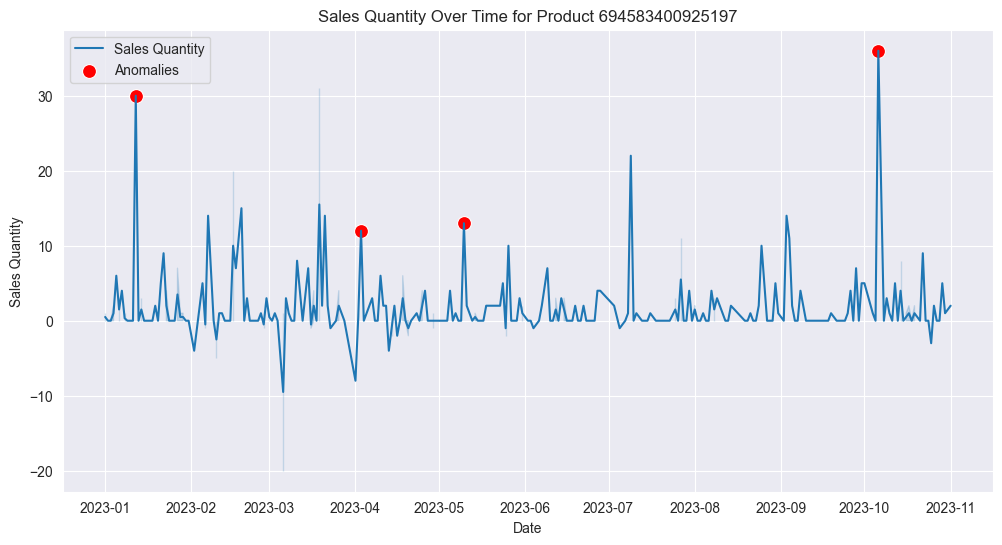

In [8]:
if not sales_anomalies.empty:
    product_to_plot = sales_anomalies["product_id"].iloc[0]
    product_data = grouped_sales[grouped_sales["product_id"] == product_to_plot].copy()

    # Ensure 'outlier' is boolean
    product_data["outlier"] = product_data["outlier"].astype(bool)

    # Plot sales quantity over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=product_data, x="date", y="sales_quantity", label="Sales Quantity"
    )

    # Plot anomalies
    anomalies = product_data[product_data["outlier"]]
    sns.scatterplot(
        data=anomalies,
        x="date",
        y="sales_quantity",
        color="red",
        label="Anomalies",
        s=100,
    )
    plt.title(f"Sales Quantity Over Time for Product {product_to_plot}")
    plt.xlabel("Date")
    plt.ylabel("Sales Quantity")
    plt.legend()
    plt.show()
else:
    print("No anomalies detected to visualize.")

### Perform anomaly detection on inventory data (if needed)

You can apply the same process to the inventory data.

In [9]:
# Function to compute z-scores and identify outliers
def detect_outliers_inventory(group):
    if len(group) > 30:
        group["z_score"] = zscore(group["inventory_quantity"])
        group["outlier"] = group["z_score"].abs() > 3.5
    else:
        group["z_score"] = np.nan
        group["outlier"] = False
    return group


inventory_df["inventory_quantity"] = inventory_df["inventory_quantity"].astype(float)

# Apply the function to each product within each time window
grouped_inventory = (
    inventory_df.groupby(["time_window", "product_id"], as_index=False)
    .apply(detect_outliers_inventory)
    .reset_index(drop=True)
)

/var/folders/yc/tk8l4tpj03s23nsy68jphwxr0000gn/T/ipykernel_13945/718405992.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_outliers_inventory)


### Examine the anomalies in inventory data

In [10]:
inventory_anomalies = grouped_inventory[grouped_inventory["outlier"]]
inventory_anomalies = (
    inventory_anomalies.groupby(["product_id", "store_id", "time_window"])
    .last()
    .reset_index()
)

print(f"Number of anomalies detected in inventory data: {len(inventory_anomalies)}")
inventory_anomalies.head()

print(f"Number of anomalies detected in inventory data: {len(inventory_anomalies)}")
print(f"Total number of inventory data points: {len(inventory_df)}")
print(
    f"Anomalies as a percentage of total inventory data: {len(inventory_anomalies) / len(inventory_df) * 100:.2f}%"
)

Number of anomalies detected in inventory data: 13174
Number of anomalies detected in inventory data: 13174
Total number of inventory data points: 20354511
Anomalies as a percentage of total inventory data: 0.06%


### Visualize the anomalies in inventory data

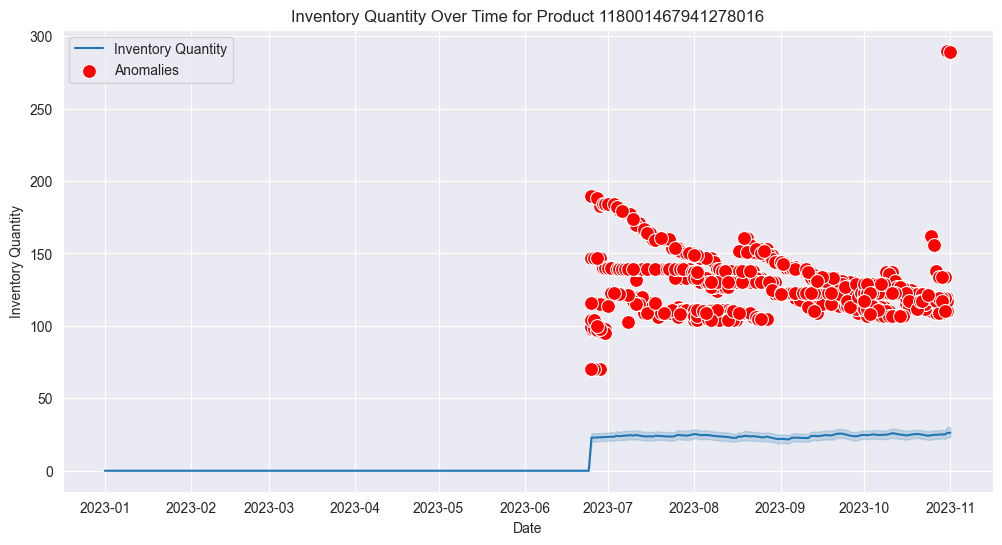

In [11]:
# Choose a product to visualize
if not inventory_anomalies.empty:
    product_to_plot = inventory_anomalies["product_id"].iloc[0]
    product_data = grouped_inventory[
        grouped_inventory["product_id"] == product_to_plot
    ].copy()

    # Ensure 'outlier' is a boolean
    product_data["outlier"] = product_data["outlier"].astype(bool)

    # Plot inventory quantity over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=product_data, x="date", y="inventory_quantity", label="Inventory Quantity"
    )

    # Plot anomalies
    anomalies = product_data[product_data["outlier"]]
    # Add hover tooltip to red dots that has store_id
    sns.scatterplot(
        data=anomalies,
        x="date",
        y="inventory_quantity",
        color="red",
        label="Anomalies",
        s=100,
    )

    plt.title(f"Inventory Quantity Over Time for Product {product_to_plot}")
    plt.xlabel("Date")
    plt.ylabel("Inventory Quantity")
    plt.legend()
    plt.show()
else:
    print("No anomalies detected to visualize.")

### Save or report the anomalies

#### Save anomalies to CSV files

In [12]:
# Save sales anomalies to a CSV file
sales_anomalies.to_csv("sales_anomalies.csv", index=False)
print("Sales anomalies saved to 'sales_anomalies.csv'.")

# Save inventory anomalies to a CSV file
inventory_anomalies.to_csv("inventory_anomalies.csv", index=False)
print("Inventory anomalies saved to 'inventory_anomalies.csv'.")

Sales anomalies saved to 'sales_anomalies.csv'.
Inventory anomalies saved to 'inventory_anomalies.csv'.


#### Save anomalies to your data warehouse

In [13]:
sales_anomalies

,product_id,store_id,time_window,date,sales_quantity,z_score,outlier
0,694583400925197,7455363607872497698,2023-01-01,2023-01-12,30.0,5.817143,True
1,694583400925197,7455363607872497698,2023-04-01,2023-04-03,12.0,3.583513,True
2,694583400925197,7455363607872497698,2023-05-01,2023-05-10,13.0,3.980439,True
3,694583400925197,7455363607872497698,2023-10-01,2023-10-06,36.0,5.066973,True
4,13100840677028524,26228510342837085,2023-03-01,2023-03-17,8.0,4.891749,True
...,...,...,...,...,...,...,...
74376,9170593861931171618,6439276602787870231,2023-01-01,2023-01-21,-5.0,-4.114242,True
74377,9170593861931171618,6951928780484453624,2023-03-01,2023-03-14,9.0,5.199857,True
74378,9170593861931171618,8120938986109419000,2023-08-01,2023-08-24,9.0,5.344460,True
74379,9170593861931171618,9193430749444361899,2023-02-01,2023-02-26,8.0,6.177844,True


In [14]:
%%save {project}.{dataset}.sales_anomalies
sales_anomalies

In [15]:
inventory_anomalies

,product_id,store_id,time_window,date,inventory_quantity,z_score,outlier
0,118001467941278016,274416775700282450,2023-06-01,2023-06-30,95.0,5.090750,True
1,118001467941278016,538717246953401588,2023-06-01,2023-06-28,98.0,5.266657,True
2,118001467941278016,538717246953401588,2023-09-01,2023-09-26,113.0,3.992741,True
3,118001467941278016,538717246953401588,2023-10-01,2023-10-10,107.0,3.530712,True
4,118001467941278016,1410343930626783872,2023-06-01,2023-06-30,184.0,10.309319,True
...,...,...,...,...,...,...,...
13169,9049183011065399697,9125856341774185011,2023-10-01,2023-10-22,667.0,3.722969,True
13170,9049183011065399697,9193430749444361899,2023-06-01,2023-06-28,470.0,5.058581,True
13171,9049183011065399697,9193430749444361899,2023-07-01,2023-07-11,544.0,3.576639,True
13172,9049183011065399697,9206472950804189232,2023-06-01,2023-06-30,345.0,3.587217,True


In [16]:
%%save {project}.{dataset}.inventory_anomalies
inventory_anomalies